In [1224]:
import numpy as np
import matplotlib.pyplot as plt

define constants

In [1225]:
sample_rate = 1e6 
N = 100 # number of observations
d= 0.5 # Half Wavelengh 
Nr = 4 # Number of sensors
t = np.arange(N)/sample_rate # time vector

defenition of  signal w/ given doa, aml-e, and freq

In [1226]:
def create_signal(theta_deg, amplitude, f_tone):
    x = (amplitude)*np.exp(2j * np.pi * f_tone * t)
    s = np.exp(-2j * np.pi * d * np.arange (Nr) * np.sin(theta_deg/180*np.pi))
    s = s.reshape(-1, 1) #column vector
    x = x.reshape(1, -1) #row vector
    X = s @ x #create steered signal X (N x Nr)
    return X

Below our "stimulus" is created

In [1227]:
theta_deg = 50 # direction of arrival

X1 = create_signal(theta_deg,  1, 0.05e6 )
n = np.random.randn(Nr, N) + 1j*np.random.randn(Nr, N)
X = X1 + 0.05*n  # X and n are both NrxN
Xsum = np.sum(X, 0)/Nr
print(Xsum.shape) # 3x10000.  X is now going to be a 2D array, 1D is time and 1D is the spatial dimension

(100,)


Visualising...

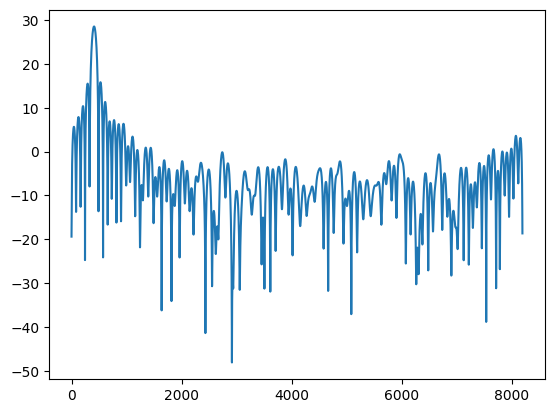

In [1228]:
plt.plot(10*np.log10(np.abs(np.fft.fft(Xsum, 8192))**2))
plt.show()

1. Initalize algorithm with:
    
    $P(0) = {1 \over \sigma_o^2}I$, I is Identity matrix

    $w(0) = v_s/N$ , 
    
    or $w(0) = w_q$

2. At each snapshot $K = 1, 2, ...$ update 

    $g(K) = {\mu^{-1} P(K-1) X(K) \over 1+ \mu^{-1} X^H(K) P(K-1) X(K)} $ , and

    $P(K) = \mu^{-1}P(K-1) - \mu^{-1} g(K) X^H(K) P(K-1)$

3. Compute $e_p = D(K) - w_{lse}(K-1) X(K)$, in other words error value
4. Compute $w_{lse}(K) =  w_{lse}(K-1) + g(K) e_p^*$, * is complex conjugate


In [1229]:
def LSE_RLS(mu, sigma_o_square, X, D):
    mu_inv = 1/mu
    P = (1/sigma_o_square)*np.eye(Nr) #P(0)
    wq = np.ones(Nr) # w(0)
    w_lse = wq
    pk = P[0]
    ekv =[]
    XX = X.T
    for k in range(len(X[2])):
        Xk = XX[k]
        gk = (mu_inv * pk @ Xk) / (1 + mu_inv * Xk.conj().T @ pk * Xk)
        pk = mu_inv * pk - mu_inv * gk @ Xk.conj().T * pk
        ek = D - w_lse.conj() @ Xk
        w_lse = w_lse + gk * ek.conj()
        ekv = np.append(ekv, ek)
    ##end for##
    print(k)
    return w_lse, ekv


99
[[-1.09055800e+67-8.60975799e+68j  5.94795215e+68+6.91981928e+68j
  -8.69967670e+68-5.99937420e+67j  6.48230912e+68-5.09862840e+68j]]


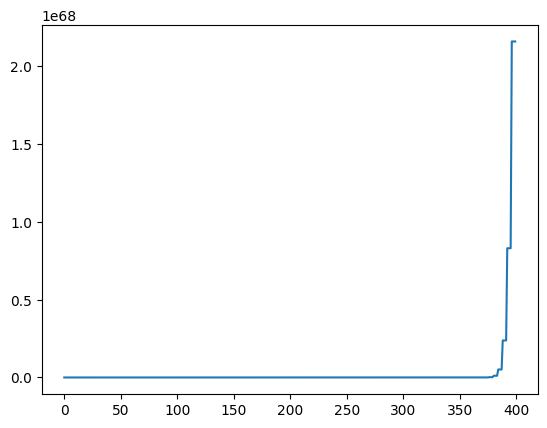

In [1230]:
d = 0.05*np.ones(Nr)
mu = 0.995
sigma_o_sqr = 0.001

w_lse, ev = LSE_RLS(mu, sigma_o_sqr, X, d)
w = w_lse.reshape(1, -1)

print(w)

plt.plot(ev)
plt.show()


polar coordinates plot

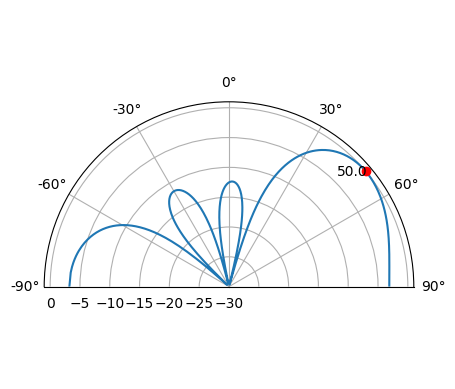

In [1231]:
N_fft = 512

w_padded = np.concatenate((w[0], np.zeros(N_fft - Nr))) # zero pad to N_fft elements to get more resolution in the FFT
w_fft_dB = 10*np.log10(np.abs(np.fft.fftshift(np.fft.fft(w_padded)))**2) # magnitude of fft in dB
w_fft_dB -= np.max(w_fft_dB) # normalize to 0 dB at peak

# Map the FFT bins to angles in radians
theta_bins = np.arcsin(np.linspace(-1, 1, N_fft)) # in radians

# find max so we can add it to plot
theta_max = theta_bins[np.argmax(w_fft_dB)]

fig, ax = plt.subplots(subplot_kw={'projection': 'polar'})
ax.plot(theta_bins, w_fft_dB) # MAKE SURE TO USE RADIAN FOR POLAR
ax.plot([theta_max], [np.max(w_fft_dB)],'ro')
ax.text(theta_max - 0.1, np.max(w_fft_dB) - 4, np.round(theta_max * 180 / np.pi))
ax.set_theta_zero_location('N') # make 0 degrees point up
ax.set_theta_direction(-1) # increase clockwise
ax.set_rlabel_position(55)  # Move grid labels away from other labels
ax.set_thetamin(-90) # only show top half
ax.set_thetamax(90)
ax.set_ylim([-30, 1]) # because there's no noise, only go down 30 dB

plt.show()

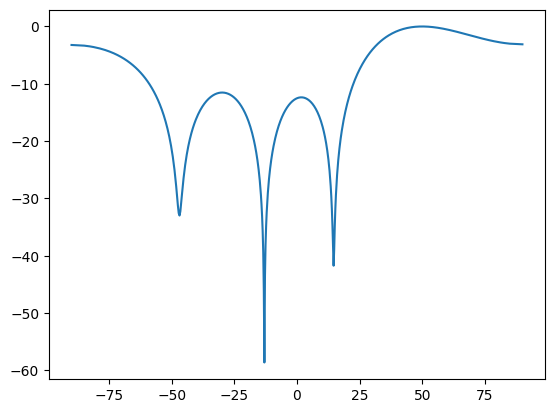

In [1232]:
theta_scan = np.arcsin(np.linspace(-1, 1, N_fft))
plt.plot(theta_scan*180/np.pi, w_fft_dB)
plt.show()

(1, 100)


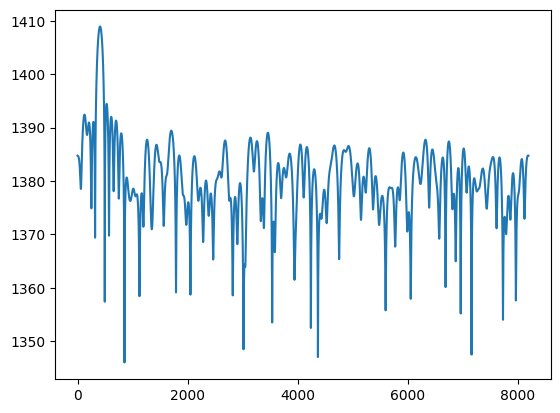

In [1233]:
Y = w.conj() @ X #instead w could be conjugated
print(Y.shape)
plt.plot(10*np.log10(np.abs(np.fft.fft(Y[0],8192))**2))
plt.show()